In [1]:
import numpy as np
import jax
import matplotlib.pyplot as plt

In [2]:
# define multivariate Gaussian pdf, in example 1 it is 2 dimensional.
def multivariate_gaussian(x, mu, cov):
    
    part1 = 1 / ( ((2* np.pi)**(len(mu)/2)) * (np.linalg.det(cov)**(1/2)) )
    part2 = (-1/2) * ((x-mu).dot(np.linalg.inv(cov))).dot((x-mu))
    return float(part1 * np.exp(part2))

In [3]:
mu = np.array([1,1])
cov = np.array([[1,0.995],[0.995,1]])

In [4]:
multivariate_gaussian([1,1], mu, cov)

1.5935426056898556

In [7]:
def log_gauss(x, mu, cov):
    scale = np.linalg.cholesky(cov)
    v = jax.lax.linalg.triangular_solve(
      scale, x - mu, left_side=True, lower=True
    )
    return -0.5 * np.sum(v * v)

def grad_log_gauss(x,mu,cov):
    scale = np.linalg.cholesky(cov)
    v = jax.lax.linalg.triangular_solve(
      scale, x - mu, left_side=True, lower=True
    )
    return - jax.lax.linalg.triangular_solve(
      np.transpose(scale), v, left_side=True, lower=False
    )

# Simple MALA for initialisation

Initialise $x_1$ and $\sigma^2$ by running simple MALA for 500 iterations where we adapt $\sigma^2$ toward acceptance rate 0.574.

When we talk about adapting the step size toward an acceptance rate of 0.574, the aim is to adjust the step size such that the overall acceptance rate of the proposed moves (over many iterations) approaches 0.574. This does not mean that acceptance rate should be 0.574 at the end of each iteration. Rather, the adaptation seeks to reach a stable state where, on average, approximately 57.4% of the proposed updates are accepted over the course of the entire sampling process.

Implementing simple MALA to initialise $x$ and step size $\sigma^2$.

In [8]:
# initialisation 
lam = 10 # default value
average_acc_rate = 0.574 # adapt step size toward achieving this acceptance rate. 
rho = 0.015

In [9]:
rng = np.random.default_rng(36)
# number of iteration
N = 500

# initialise step size which is sigma^2 in paper
# 0.02 seems reasonable from trials
step_size = 0.02


#initial sample obtained by drawing from standard normal as stated
a=rng.normal(0,1)
b=rng.normal(0,1)
x = np.array([a,b]) # initial values

# 500 iterations. 
for _ in range(N):
    
    # obtain x' through the formula
    y = x + (step_size/2) * grad_log_gauss(x, mu, cov) + np.sqrt(step_size) * rng.normal(0,1,2)
    
    # Metropolis
    u = rng.uniform(0, 1)
    
    log_acc_rate = log_gauss(y, mu, cov) + log_gauss(x, y+step_size/2 *grad_log_gauss(y,mu,cov), step_size * np.identity(2)) - \
            (log_gauss(x, mu, cov) + log_gauss(y, x + step_size/2 *grad_log_gauss(x,mu,cov) , step_size * np.identity(2)))
    
    # if u < acceptance rate, we accept the sample 
    if np.log(u) < log_acc_rate:
        x = y
        
    else:
        x = x
        
    # adapt the step size toward 0.574
    acc_rate = min(1, np.exp(log_acc_rate))


    # Step size adaptation towards the optimal acceptance rate
    step_size = step_size * (1+ rho * (acc_rate - average_acc_rate))
    
print(f'Final sample in first 500 iterations:{x}')
print(f'Final adapted step size in first 500 iterations:{step_size}')
                                   

Final sample in first 500 iterations:[0.0144401 0.0021977]
Final adapted step size in first 500 iterations:0.017667425040783776


This suggest that the adapting step size is working as expected.0.558 is close to average acceptance rate 0.574 that we aim for given that we started off with a good initial step size 0.02.

# Fisher MALA

Now implement Fisher adaptive MALA for the remaining $1.95 * 10^4$ burn-in iterations before we can collect any samples.

In [10]:
# initialisation
N = int(1.95 * 10**4)
step_size_R = step_size # adapted step size from final iteration above. place holder for normalised step size.
R = np.identity(2) # initialise the square root matrix with identity matrix.

In [11]:
# define function h as stated in proposition 1. 
def h(z,v, step_size, R, mu, cov):
    return (1/2) * (z- v- (step_size/4)* (R @ (R.T)).dot(grad_log_gauss(v, mu, cov))).dot(grad_log_gauss(v, mu, cov))


In [12]:
acc_rate_collection = []

normalised_preconditioner_fisher = []

for n in range(1,N+1):
    
    # append normalised matrix to a list for plotting Frobenius norm later 
    normalised_preconditioner_fisher.append(R@R.T/(1/2 * np.trace(R@R.T)))
    
    y = x + step_size_R/2 * R.dot(R.T.dot(grad_log_gauss(x, mu, cov))) + np.sqrt(step_size_R) * R.dot(rng.normal(0,1,2))
    
    # using proposition 1 to compute acceptance rate, mistake for using step_size_R as step size
    acc_rate = min(1, np.exp(log_gauss(y, mu, cov) + h(x, y, step_size_R, R, mu, cov) -\
                     log_gauss(x, mu, cov) - h(y, x, step_size_R, R, mu, cov)))
    
    # collect acceptance rate
    acc_rate_collection.append(acc_rate)
    
    # compute adaptation signal for updating R later
    s = np.sqrt(acc_rate) * (grad_log_gauss(y, mu, cov) - grad_log_gauss(x, mu, cov))
    
    # use s to adapt R based on proposition 4
    if n == 1:
        r1 = 1/(1+ np.sqrt(lam/(lam + np.dot(s,s))))
        R = (1/ np.sqrt(lam))* (R - r1 * (np.outer(s,s)/(lam + np.dot(s,s))))
    else:
        phi = (R.T).dot(s)
        r = 1/(1+ np.sqrt(1/ (1+np.dot(phi,phi))))
        R = R - r * np.outer((R.dot(phi)),phi)/(1+ np.dot(phi,phi))
    

    # let the step size adapt as before in Simple MALA
    step_size = step_size * (1+ rho * (acc_rate - average_acc_rate))
    
    # normalise the step size for the proposal in next iteration.
    step_size_R = step_size / ((1/2) * np.trace(R @ (R.T))) 
    
    # Metropolis step - accept/ reject y  with probability acc_rate
    u = rng.uniform(0, 1)
    
    if u < acc_rate:
        x = y
        
    else:
        x = x
    

In [13]:
print(f'Final sample after burn-in iterations:{x}')
print(f'Final adapted step size after burn-in iterations:{step_size_R}')
print(f'Average acceptance rate:{np.mean(acc_rate_collection)}')
print(f'Adapted square root matrix:{R}')

Final sample after burn-in iterations:[2.9151568 2.8057227]
Final adapted step size after burn-in iterations:64671.21510357355
Average acceptance rate:0.5915676934848507
Adapted square root matrix:[[0.00447444 0.00378635]
 [0.00408119 0.00421218]]


In [14]:
print(f'preconditioning matrix:{R@R.T}')

preconditioning matrix:[[3.43570216e-05 3.42098396e-05]
 [3.42098396e-05 3.43986324e-05]]


In [15]:
A = R@R.T
FisherMALA_cov = A/(1/2 * np.trace(A))
print(f'normalised preconditioning matrix:{FisherMALA_cov}')

normalised preconditioning matrix:[[0.9993948  0.99511349]
 [0.99511349 1.0006052 ]]


## Multivariate Gaussian with estimated covariance by Fisher MALA in orange dash line. True covariance in blue line.

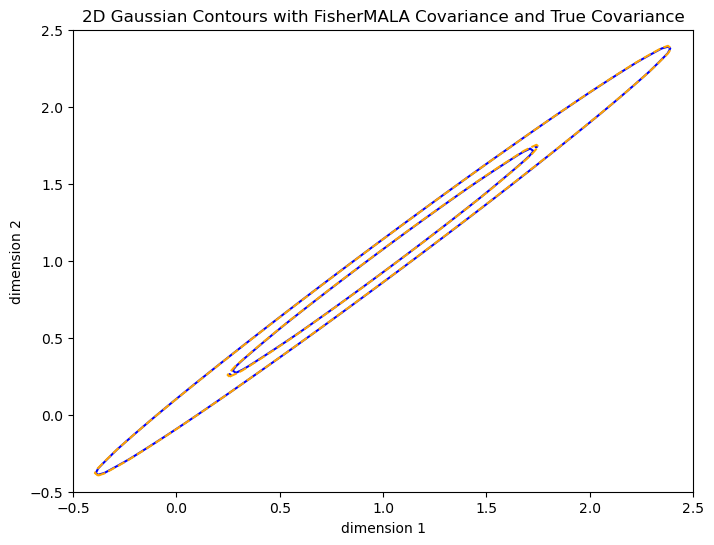

In [16]:
# Updated code
x = np.linspace(-0.5, 2.5, 100)
y = np.linspace(-0.5, 2.5 , 100)
X, Y = np.meshgrid(x, y)
Z = np.zeros(X.shape)
T = np.zeros(X.shape)
# Calculate the function value for each point on the grid
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z[i,j] = multivariate_gaussian(np.array([X[i,j], Y[i,j]]), mu, FisherMALA_cov)
        T[i,j] = multivariate_gaussian(np.array([X[i,j], Y[i,j]]), mu, cov)


# Plot the contour map
plt.figure(figsize=(8, 6))
plt.contour(X, Y , T , 2, colors='blue') # Blue contour has the true covariance
plt.contour(X, Y , Z , 2, colors='orange', linestyles='dashed') # Orange contour has the estimated FisherMALA covariance
plt.title('2D Gaussian Contours with FisherMALA Covariance and True Covariance')
plt.xlabel('dimension 1')
plt.ylabel('dimension 2')
plt.show()

It is performing well. 

## Sampling phase with adapted R

In [17]:
# initialisation
N = int(2 * 10**4)
Fisher_MALA_samples = np.zeros((2, N+1))

a=rng.normal(0,1)
b=rng.normal(0,1)


Fisher_MALA_samples[:, 0] = np.array([a,b])

for n in range(1, N+1):
    y = Fisher_MALA_samples[:,n-1] + step_size_R/2 * R.dot(R.T.dot(grad_log_gauss(Fisher_MALA_samples[:,n-1], mu, cov))) + np.sqrt(step_size_R) * R.dot(rng.normal(0,1,2))
    
    
    # using proposition 1 to compute acceptance rate, mistake for using step_size_R as step size
    acc_rate = min(1, np.exp(log_gauss(y, mu, cov) + h(Fisher_MALA_samples[:, n-1], y, step_size_R, R, mu, cov) -\
                     log_gauss(Fisher_MALA_samples[:, n-1], mu, cov) - h(y, Fisher_MALA_samples[:, n-1], step_size_R, R, mu, cov)))
    
    # Metropolis step - accept/ reject y  with probability acc_rate
    u = rng.uniform(0, 1)
    
    if u < acc_rate:
        Fisher_MALA_samples[:,n] = y

    else:
        Fisher_MALA_samples[:,n]  = Fisher_MALA_samples[:,n-1]

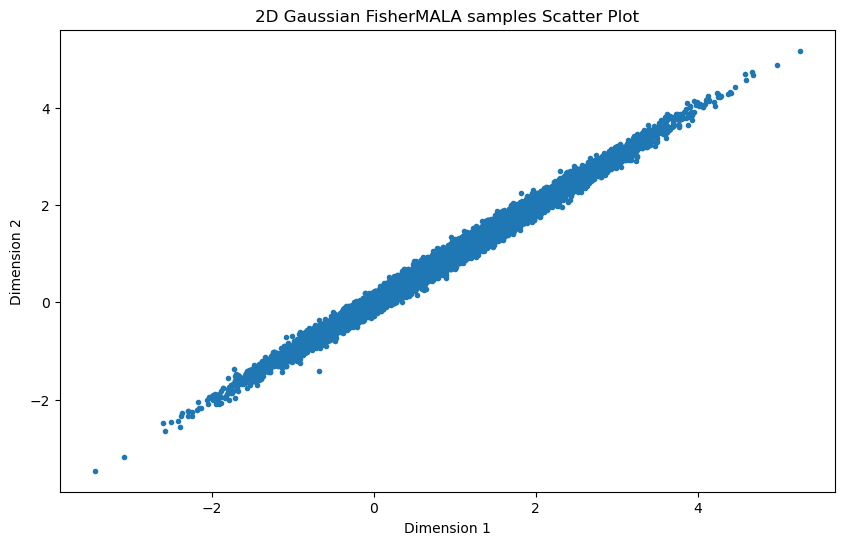

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(Fisher_MALA_samples[0, :], Fisher_MALA_samples[1, :], 'o', markersize=3)
plt.title('2D Gaussian FisherMALA samples Scatter Plot')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

# AdaMALA
Implement AdaMALA using the provided the way to initialise it in Appendix. 

First 500 iterations of simple MALA to adapt step size only, same step as above for FisherMALA.

In [21]:
mu = np.array([1,1])
cov = np.array([[1, 0.995], [0.995, 1]])

rng = np.random.default_rng(36)
N = 500

# initialise step size which is sigma^2 in paper
# 0.02 seems reasonable from trials
step_size = 0.02


#initial sample obtained by drawing from standard normal as stated
a=rng.normal(0,1)
b=rng.normal(0,1)
x = np.array([a,b]) # initial values

# 500 iterations. 
for _ in range(N):
    
    # obtain x' through the formula
    y = x + (step_size/2 * grad_log_gauss(x, mu, cov) + np.sqrt(step_size) * rng.normal(0,1,2))
    
    # Metropolis
    u = rng.uniform(0, 1)
    
    log_acc_rate = log_gauss(y, mu, cov) + log_gauss(x, y+step_size/2 *grad_log_gauss(y,mu,cov), step_size * np.identity(2)) - \
            (log_gauss(x, mu, cov) + log_gauss(y, x + step_size/2 *grad_log_gauss(x,mu,cov) , step_size * np.identity(2)))
    
    # if u < acceptance rate, we accept the sample 
    if np.log(u) < log_acc_rate:
        x = y
        
    else:
        x = x
        
    # adapt the step size toward 0.574
    acc_rate = min(1, np.exp(log_acc_rate))


    # Step size adaptation towards the optimal acceptance rate
    step_size = step_size * (1+ rho * (acc_rate - average_acc_rate))
    
print(f'Final sample in first 500 iterations:{x}')
print(f'Final adapted step size in first 500 iterations:{step_size}')
                                   

Final sample in first 500 iterations:[0.01444016 0.0021976 ]
Final adapted step size in first 500 iterations:0.017667423997448445


Another 500 iterations to collect samples that are used to sequentially update empiriacl covariance matrix to provide a reasonable covariance for further burn-in steps.

Update the mean and the covariance matrix on the collected samples, otherwise it won't work. 

In [22]:
# initialisation mu with final sample from first 500 iterations.
mean = x

# number of iteration
N = 500

normalised_preconditioner_ada = []


# 500 iterations. 
for n in range(2, N+2):
    
    # obtain x' through the formula
    y = x + (step_size/2 * grad_log_gauss(x, mu, cov) + np.sqrt(step_size) * rng.normal(0,1,2))
    
    # Metropolis
    u = rng.uniform(0, 1)
    
    log_acc_rate = log_gauss(y, mu, cov) + log_gauss(x, y+step_size/2 *grad_log_gauss(y,mu,cov), step_size * np.identity(2)) - \
            (log_gauss(x, mu, cov) + log_gauss(y, x + step_size/2 *grad_log_gauss(x,mu,cov) , step_size * np.identity(2)))
    
    # if u < acceptance rate, we accept the sample 
    if np.log(u) < log_acc_rate:
        x = y
        
    else:
        x = x
        
        
    if n == 2:
        Sigma = (1/2)* np.outer((x-mean),(x-mean)) + lam * np.identity(2)
    
    else:
        Sigma = ((n-2)/(n-1)) * Sigma + 1/n * np.outer((x-mean), (x-mean))
        
    # append normalised matrix for plot of Frobenius norm 
    normalised_preconditioner_ada.append(Sigma/(1/2 * np.trace(Sigma)))
        
    mean = mean + (1./n) * (x - mean)
    
        
    # adapt the step size toward 0.574
    acc_rate = min(1, np.exp(log_acc_rate))


    # Step size adaptation towards the optimal acceptance rate
    step_size = step_size * (1+ rho * (acc_rate - average_acc_rate))

print(f'Final empirical covariance after 500 iterations:{Sigma}')
print(f'Final empirical mean after 500 iterations:{mean}')
print(f'Final adapted step size after first 1000 iterations:{step_size}')

Final empirical covariance after 500 iterations:[[0.44404761 0.41534626]
 [0.41534626 0.43698908]]
Final empirical mean after 500 iterations:[0.25664276 0.25614116]
Final adapted step size after first 1000 iterations:0.016610561985021945


In [23]:
# initialisation
N = int(1.9 * 10**4)

step_size_R = step_size # adapted step size from final iteration above. place holder for normalised step size.

acc_rate_collection = []

mean = mean # final sample from above
Sigma = Sigma # from above. 

# for n in range(3,N+3):
for n in range(502,N+502):
    R = np.linalg.cholesky(Sigma)

    y = x + step_size_R/2 * Sigma.dot(grad_log_gauss(x, mu, cov)) + np.sqrt(step_size_R) * R.dot(rng.normal(0,1,2))
    
    # using proposition 1 to compute acceptance rate, mistake for using step_size_R as step size
    acc_rate = min(1, np.exp(log_gauss(y, mu, cov) + h(x, y, step_size_R, R, mu, cov) -\
                     log_gauss(x, mu, cov) - h(y, x, step_size_R, R, mu, cov)))
    
    # collect acceptance rate
    acc_rate_collection.append(acc_rate)
    
    # Metropolis step - accept/ reject y  with probability acc_rate
    u = rng.uniform(0, 1)
    
    if u < acc_rate:
        x = y
        
    else:
        x = x
        

    Sigma = ((n-2)/(n-1)) * Sigma + 1/n * np.outer((x-mean), (x-mean))
    
    mean = (n-1)/n * mean + 1/n * x
    
    # appending the normalised preconditioner for later plot of Frobenius norm
    normalised_preconditioner_ada.append(Sigma/(1/2 * np.trace(Sigma)))
    
    # let the step size adapt as before in Simple MALA
    step_size = step_size * (1+ rho * (acc_rate - average_acc_rate))
    
    # normalise the step size for the proposal in next iteration.
    step_size_R = step_size / ((1/2) * np.trace(Sigma)) 
    


In [24]:
print(f'Final empirical covariance after burn-in iterations:{Sigma}')
print(f'Final empirical mean after burn-in iterations:{mean}')
print(f'average acceptance rate:{np.mean(acc_rate_collection)}') 

Final empirical covariance after burn-in iterations:[[1.01923511 1.01164362]
 [1.01164362 1.01513868]]
Final empirical mean after burn-in iterations:[0.9807611  0.98065513]
average acceptance rate:0.5920832266676366


# Multivariate Gaussian with estimated covariance by AdaMALA in red dash line. True covariance in blue line.

In [25]:
AdaMALA_cov = Sigma/(1/2* np.trace(Sigma))
print(f'normalised precondtioning matrix:{AdaMALA_cov}') # N = 1.9

normalised precondtioning matrix:[[1.00201361 0.99455038]
 [0.99455038 0.99798639]]


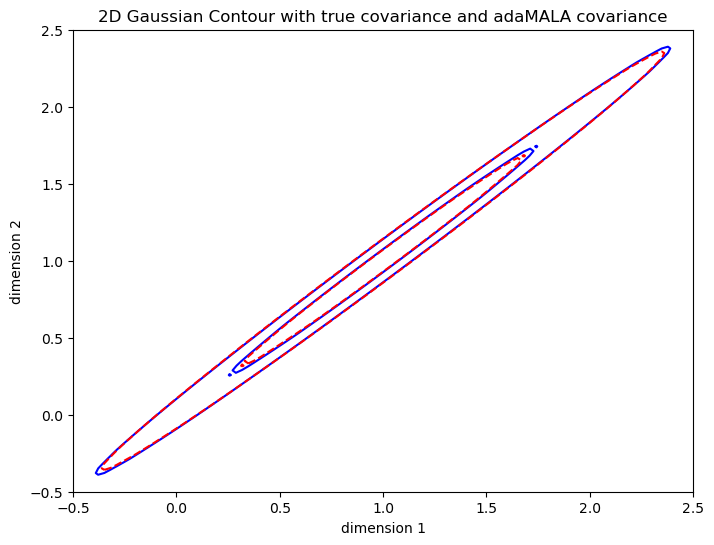

In [26]:
# Updated code
x = np.linspace(-0.5, 2.5, 100)
y = np.linspace(-0.5, 2.5 , 100)
X, Y = np.meshgrid(x, y)
Z = np.zeros(X.shape)
T = np.zeros(X.shape)
# Calculate the function value for each point on the grid
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z[i,j] = multivariate_gaussian(np.array([X[i,j], Y[i,j]]), mu, AdaMALA_cov)
        T[i,j] = multivariate_gaussian(np.array([X[i,j], Y[i,j]]), mu, cov)


# Plot the contour map
plt.figure(figsize=(8, 6))
plt.contour(X, Y , T , 2, colors='blue')
plt.contour(X, Y , Z , 2, colors='red', linestyles='dashed')
plt.title('2D Gaussian Contour with true covariance and adaMALA covariance')
plt.xlabel('dimension 1')
plt.ylabel('dimension 2')
plt.show()

## Now we enter the sampling phase, perform $2 * 10^4$ iterations for collecting samples, remove any adaptation steps.

In [27]:
# initialisation
N = int(2 * 10**4)
adaMALA_samples = np.zeros((2, N+1))

a=rng.normal(0,1)
b=rng.normal(0,1)
adaMALA_samples[:, 0] = np.array([a,b])

for n in range(1, N+1):
    
    R = np.linalg.cholesky(Sigma)
    # mistake here did not sqrt stepsizeR 
    y = adaMALA_samples[:, n-1] + step_size_R/2 * Sigma.dot(grad_log_gauss(adaMALA_samples[:, n-1], mu, cov)) + np.sqrt(step_size_R) * R.dot(rng.normal(0,1,2))
    
    
    # using proposition 1 to compute acceptance rate, mistake for using step_size_R as step size
    acc_rate = min(1, np.exp(log_gauss(y, mu, cov) + h(adaMALA_samples[:, n-1], y, step_size_R, R, mu, cov) -\
                     log_gauss(adaMALA_samples[:, n-1], mu, cov) - h(y, adaMALA_samples[:, n-1], step_size_R, R, mu, cov)))
    
    
    
    # Metropolis step - accept/ reject y  with probability acc_rate
    u = rng.uniform(0, 1)
    
    if u < acc_rate:
        adaMALA_samples[:,n] = y
        
    else:
        adaMALA_samples[:,n]  = adaMALA_samples[:,n-1]

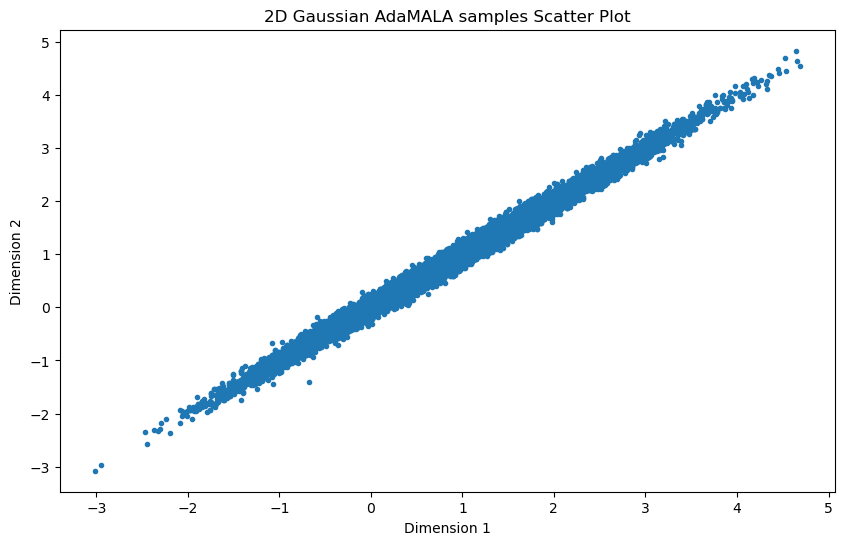

In [28]:
plt.figure(figsize=(10, 6))
plt.plot(adaMALA_samples[0, :], adaMALA_samples[1, :], 'o', markersize=3)
plt.title('2D Gaussian AdaMALA samples Scatter Plot')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

# Frobenius norm Figure 5
All normalised preconditioning matrix generated throughout the iterations has to be stored in a list, we substract the true covariance from the normalised preconditioning matrix through broadcasting, then compute Frobenius norm by linalg.norm(matrix) for each element in the list. 

In [29]:
difference_ada = normalised_preconditioner_ada - cov
difference_fisher = normalised_preconditioner_fisher - cov
fro_norm_ada = []
fro_norm_fisher = []
for i in difference_ada:
    fro_norm_ada.append(np.linalg.norm(i))
    
for j in difference_fisher:
    fro_norm_fisher.append(np.linalg.norm(j))

In [30]:
iterations = np.arange(0, int(1.95 * 10**4))

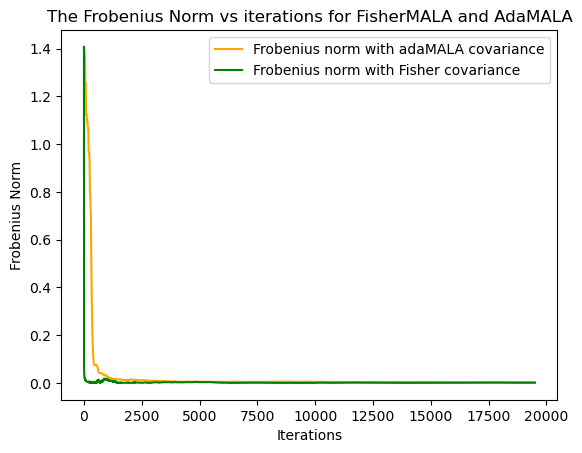

In [31]:
plt.plot(iterations, fro_norm_ada, label = 'Frobenius norm with adaMALA covariance', color = 'orange')
plt.plot(iterations, fro_norm_fisher, label = 'Frobenius norm with Fisher covariance', color = 'green')
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Frobenius Norm')
plt.title('The Frobenius Norm vs iterations for FisherMALA and AdaMALA')
plt.show()

In [32]:
print(f'Frobenius norm from FisherMALA converges to:{fro_norm_fisher[-1]}')
print(f'Frobenius norm from AdaMALA converges to:{fro_norm_ada[-1]}')

Frobenius norm from FisherMALA converges to:0.0008348179964713648
Frobenius norm from AdaMALA converges to:0.002917800064912022
